In [1]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import torch.nn as nn
from HMCTrainer import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

Define the neural network

In [3]:
width = 20
net = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1),
)

Define the data

In [4]:
N_tr = 20
N_val = 300

In [5]:
# Create validation data
x_val = torch.linspace(-1, 1, N_val).view(-1, 1).to(device)
y_val = (0.4 * torch.sin(4 * x_val) + 0.5 *
         torch.cos(12 * x_val)).view(-1, 1).to(device)

# Create training data
x_train = torch.cat((torch.linspace(-1, -0.2, int(N_tr / 2)),
                     torch.linspace(0.2, 1, int(N_tr / 2)))).view(-1, 1).to(device)
y_train = (0.4 * torch.sin(4 * x_train) + 0.5 * torch.cos(12 * x_train) +
           torch.randn_like(x_train) * 0.05).view(-1, 1).to(device)

Define HMC parameters

In [6]:
params_init = hamiltorch.util.flatten(net).to(device).clone()

In [7]:
tau_list = []
tau = 1.0  # prior variance
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [8]:
step_size = 5e-4  # Step size of the leap frog step
num_samples = 1000  # number of samples to draw from the posterior distribution
L = 100  # Number of leap frog steps
# precision parameter in the Gaussian log likelihood function
tau_out = 1/(0.05)**2

Initialize and run HMC training

In [9]:
params_hmc_path = "params_hmc.pt"
trainer = HMCTrainer(net=net, device=device, params_hmc_path=params_hmc_path)
params_hmc, pred_list, log_prob_list = trainer.run_training(
    X_tr=x_train,
    Y_tr=y_train,
    X_val=x_val,
    Y_val=y_val,
    loss_function=nn.MSELoss(),
    num_samples_hmc=num_samples,
    L=L,
    step_size=step_size,
    burn_sample=200,
    burn_pred=200,
    tau_out=tau_out,
    tau_list=tau_list
)

0
1
2
3
4
5
6
7
8
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:01:17 | 0d:00:00:00 | #################### | 1000/1000 | 12.89       
Acceptance Rate 0.58
0
1
2
3
4
5
6
7
8


Load parameters and make predictions

Calculate and print expected MSE

In [10]:
print('\nExpected MSE: {:.2f}'.format(
    ((pred_list.mean(0) - y_val) ** 2).mean()))


Expected MSE: 0.02


Plot results

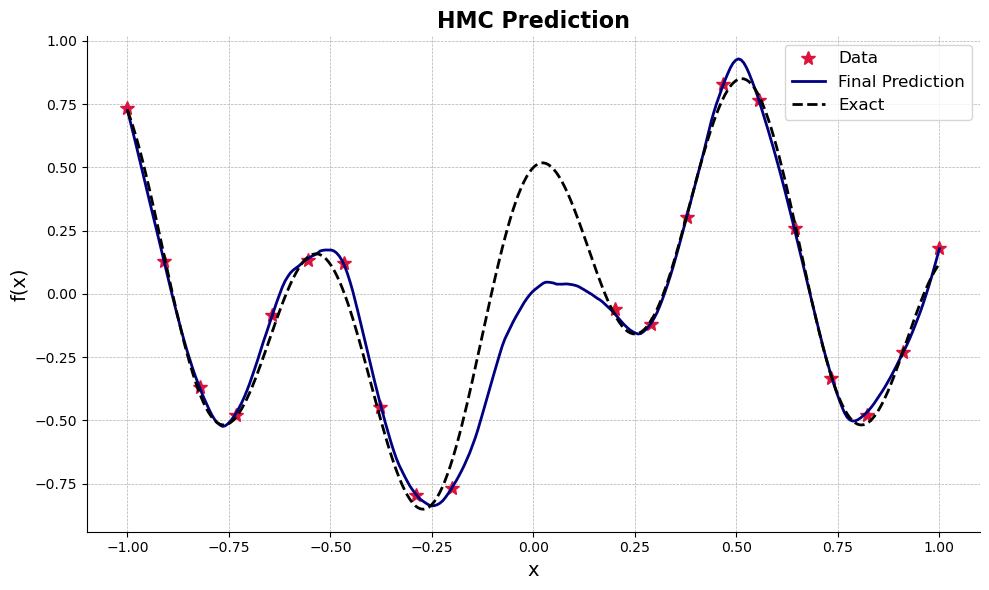

In [11]:
pred = pred_list.mean(0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(),
        '*', label="Data", color='crimson', markersize=10)
ax.plot(x_val.cpu().numpy(), pred.cpu().numpy(),
        label="Final Prediction", color='navy', linewidth=2)
ax.plot(x_val.cpu().numpy(), y_val.cpu().numpy(), label="Exact",
        color="black", linestyle="dashed", linewidth=2)
ax.set_title("HMC Prediction", fontsize=16, fontweight='bold')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("f(x)", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [12]:
sigma = pred_list.std(0).detach()
total_sigma = torch.sqrt(sigma**2 + 0.05**2).detach()
mu = pred.detach()

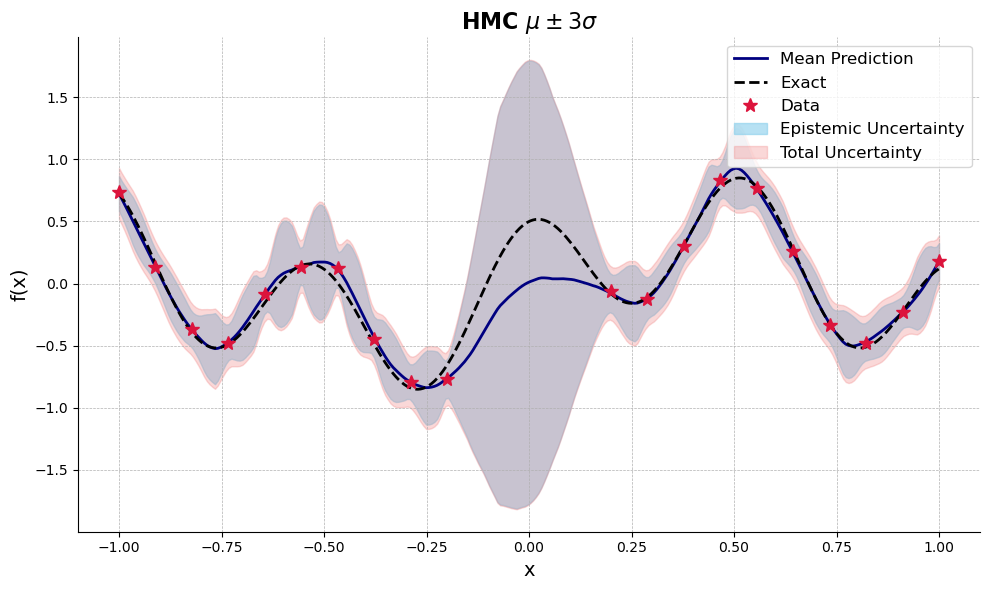

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_val.cpu().numpy(), mu.cpu().numpy(),
        label="Mean Prediction", color='navy', linewidth=2)
ax.plot(x_val.cpu().numpy(), y_val.cpu().numpy(), label="Exact",
        color="black", linestyle="dashed", linewidth=2)
ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(),
        '*', label="Data", color='crimson', markersize=10)
ax.fill_between(x_val.view(-1).cpu().numpy(), mu.view(-1).cpu().numpy() - (3 * sigma.view(-1).cpu().numpy()),
                mu.view(-1).cpu().numpy() + (3 * sigma.view(-1).cpu().numpy()), label="Epistemic Uncertainty", color='skyblue', alpha=0.6)
ax.fill_between(x_val.view(-1).cpu().numpy(), mu.view(-1).cpu().numpy() - (3 * total_sigma.view(-1).cpu().numpy()),
                mu.view(-1).cpu().numpy() + (3 * total_sigma.view(-1).cpu().numpy()), label="Total Uncertainty", color='lightcoral', alpha=0.3)
ax.set_title("HMC $\mu \pm 3\sigma$", fontsize=16, fontweight='bold')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("f(x)", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('HMC_BNN.png')
plt.show()